In [1]:
# Change directory
import os
os.chdir("..")

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from raw_slope_functions import calculate_slopes_se, run_ttest

In [3]:
# import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv")

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

In [7]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit, cal_window_size, sampleDelimit, sample_window_size):
    cal_window_start = bubble_start - calDelimit
    cal_window_end = cal_window_start + cal_window_size
    sample_window_start = sample_start + sampleDelimit
    sample_window_end = sample_window_start + sample_window_size
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# For sensor A in system 1
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start = A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start = A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size
                                                                                                   )
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# For sensor A in system 2
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end

In [8]:
# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

# For sensor B in system 1, blood and aqueous
B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

In [9]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# extract window data for sensor A in system 1
A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)
A1_cal_window.dropna(inplace=True)
A1_sample_window.dropna(inplace=True)

# extract window data for sensor A in system 2
A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)
A2_cal_window.dropna(inplace=True)
A2_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 1
B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID']
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)
B1_cal_window.dropna(inplace=True)
B1_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 2
B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID']
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)
B2_cal_window.dropna(inplace=True)
B2_sample_window.dropna(inplace=True)


In [10]:
# Merge attributes with extracted cal and sample window

# Sensor A
A1_attributes = A1_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
A1_cal_window = A1_cal_window.reset_index()
A1_cal_window_binned = A1_attributes.merge(A1_cal_window, how = "inner", on = "TestID")
A1_sample_window = A1_sample_window.reset_index()
A1_sample_window_binned = A1_attributes.merge(A1_sample_window, how = "inner", on = "TestID")

A2_attributes = A2_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
A2_cal_window = A2_cal_window.reset_index()
A2_cal_window_binned = A2_attributes.merge(A2_cal_window, how = "inner", on = "TestID")
A2_sample_window = A2_sample_window.reset_index()
A2_sample_window_binned = A2_attributes.merge(A2_sample_window, how = "inner", on = "TestID")

# Sensor B
B1_attributes = B1_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
B1_cal_window = B1_cal_window.reset_index()
B1_cal_window_binned = B1_attributes.merge(B1_cal_window, how = "inner", on = "TestID")
B1_sample_window = B1_sample_window.reset_index()
B1_sample_window_binned = B1_attributes.merge(B1_sample_window, how = "inner", on = "TestID")

B2_attributes = B2_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
B2_cal_window = B2_cal_window.reset_index()
B2_cal_window_binned = B2_attributes.merge(B2_cal_window, how = "inner", on = "TestID")
B2_sample_window = B2_sample_window.reset_index()
B2_sample_window_binned = B2_attributes.merge(B2_sample_window, how = "inner", on = "TestID")

In [11]:
# Calculate sample size for each system and sensors calibration and sample window
N_A1_cal = A1_cal_window.shape[1]
N_A2_cal = A2_cal_window.shape[1]
N_A1_sample = A1_sample_window.shape[1]
N_A2_sample = A2_sample_window.shape[1]

N_B1_cal = B1_cal_window.shape[1]
N_B2_cal = B2_cal_window.shape[1]
N_B1_sample = B1_sample_window.shape[1]
N_B2_sample = B2_sample_window.shape[1]

# **Card Age**

## **Sensor A**

In [12]:
# Making bins and adding df column of the bin
bins = [0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252]
labels = ['0-9', '9-28', '28-56', '56-84', '84-112', '112-140', '140-168', '168-196', '196-224', '224-252']

# binning time stamps
A1_cal_window_binned['A1-cal-age'] = pd.cut(A1_cal_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)
A1_sample_window_binned['A1-sample-age'] = pd.cut(A1_sample_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)

A2_cal_window_binned['A2-cal-age'] = pd.cut(A2_cal_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)
A2_sample_window_binned['A2-sample-age'] = pd.cut(A2_sample_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)

In [13]:
# Slopes and SE
A1_cal = calculate_slopes_se(A1_cal_window_binned, "A1-cal-age", labels)
A1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

A1_sample = calculate_slopes_se(A1_sample_window_binned, "A1-sample-age", labels)
A1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

A2_cal = calculate_slopes_se(A2_cal_window_binned, "A2-cal-age", labels)
A2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

A2_sample = calculate_slopes_se(A2_sample_window_binned, "A2-sample-age", labels)
A2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_A_slopes = pd.concat([A1_cal, A2_cal, A1_sample, A2_sample],axis = 1)
Sensor_A_slopes.index = labels
Sensor_A_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
0-9,-0.006167,0.000012,-0.007658,0.000034,-0.011012,0.000096,-0.007373,0.000067
9-28,-0.002812,0.000010,0.003282,0.000013,-0.011105,0.000109,0.001438,0.000135
28-56,0.014418,0.000017,0.018167,0.000013,0.003826,0.000128,0.015167,0.000128
56-84,0.023225,0.000039,0.020604,0.000006,0.007879,0.000177,0.016480,0.000137
84-112,0.021514,0.000035,0.020576,0.000006,0.007033,0.000188,0.016928,0.000109
112-140,0.020769,0.000038,0.020164,0.000007,0.006071,0.000184,0.016647,0.000099
140-168,0.019234,0.000040,0.018648,0.000006,0.004381,0.000190,0.014963,0.000099
168-196,0.018131,0.000044,0.021983,0.000004,0.003531,0.000191,0.018746,0.000115
196-224,0.021195,0.000043,0.027566,0.000010,0.007057,0.000192,0.022471,0.000114
224-252,0.024732,0.000048,0.032866,0.000021,0.010183,0.000199,0.026918,0.000115


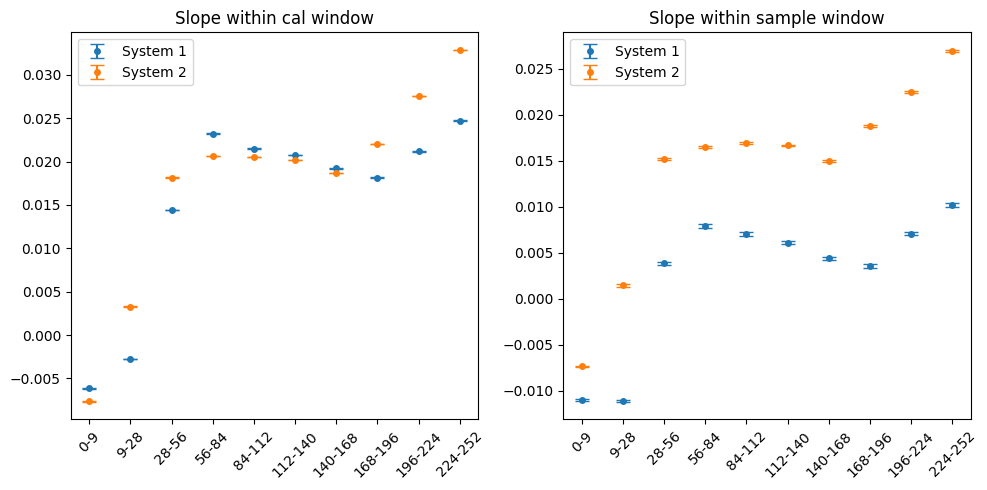

In [14]:
# Plot of slopes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-1-cal-slope"], yerr=Sensor_A_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-2-cal-slope"], yerr=Sensor_A_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-1-sample-slope"], yerr=Sensor_A_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-2-sample-slope"], yerr=Sensor_A_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

plt.tight_layout()
plt.show()


In [15]:
# T-tests to compare slopes in each bin
ttest_A = run_ttest(Sensor_A_slopes, N_A1_cal, N_A2_cal, N_A1_sample, N_A2_sample, labels)
ttest_A

,t-statistic-cal,p-value-cal,t-statistic-sample,p-value-sample
0-9,41.372843,0.0,-31.150710,0.0
9-28,-361.855274,0.0,-72.445685,0.0
28-56,-173.716596,0.0,-62.487666,0.0
56-84,66.729533,0.0,-38.391019,0.0
84-112,26.060094,0.0,-45.516297,0.0
112-140,15.782989,0.0,-50.740842,0.0
140-168,14.334316,0.0,-49.307080,0.0
168-196,-86.602288,0.0,-68.267739,0.0
196-224,-143.865271,0.0,-69.061333,0.0
224-252,-155.984248,0.0,-72.677117,0.0


## **Sensor B**

In [16]:
# Making bins and adding df column of the bin
bins = [0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252]
labels = ['0-9', '9-28', '28-56', '56-84', '84-112', '112-140', '140-168', '168-196', '196-224', '224-252']

# binning time stamps
B1_cal_window_binned['B1-cal-age'] = pd.cut(B1_cal_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)
B1_sample_window_binned['B1-sample-age'] = pd.cut(B1_sample_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)

B2_cal_window_binned['B2-cal-age'] = pd.cut(B2_cal_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)
B2_sample_window_binned['B2-sample-age'] = pd.cut(B2_sample_window_binned['AgeOfCardInDaysAtTimeOfTest'], bins=bins, labels=labels)

In [17]:
# Slopes
B1_cal = calculate_slopes_se(B1_cal_window_binned, "B1-cal-age", labels)
B1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

B1_sample = calculate_slopes_se(B1_sample_window_binned, "B1-sample-age", labels)
B1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

B2_cal = calculate_slopes_se(B2_cal_window_binned, "B2-cal-age", labels)
B2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

B2_sample = calculate_slopes_se(B2_sample_window_binned, "B2-sample-age", labels)
B2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_B_slopes = pd.concat([B1_cal, B2_cal, B1_sample, B2_sample],axis = 1)
Sensor_B_slopes.index = labels
Sensor_B_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
0-9,0.043253,0.000024,0.048489,0.000041,0.045018,0.000082,0.051280,0.000082
9-28,0.024664,0.000019,0.037447,0.000044,0.033367,0.000207,0.040047,0.000121
28-56,0.033586,0.000031,0.040463,0.000047,0.035715,0.000155,0.043108,0.000149
56-84,0.040411,0.000052,0.041460,0.000052,0.039461,0.000171,0.044524,0.000184
84-112,0.039765,0.000052,0.041972,0.000040,0.036129,0.000144,0.043531,0.000160
112-140,0.038817,0.000052,0.040916,0.000042,0.033452,0.000130,0.039902,0.000146
140-168,0.035541,0.000049,0.039169,0.000039,0.031762,0.000135,0.040565,0.000150
168-196,0.035471,0.000051,0.044460,0.000054,0.034635,0.000146,0.045511,0.000177
196-224,0.033193,0.000047,0.046830,0.000058,0.033287,0.000161,0.045936,0.000166
224-252,0.036990,0.000051,0.048599,0.000067,0.037504,0.000161,0.046160,0.000162


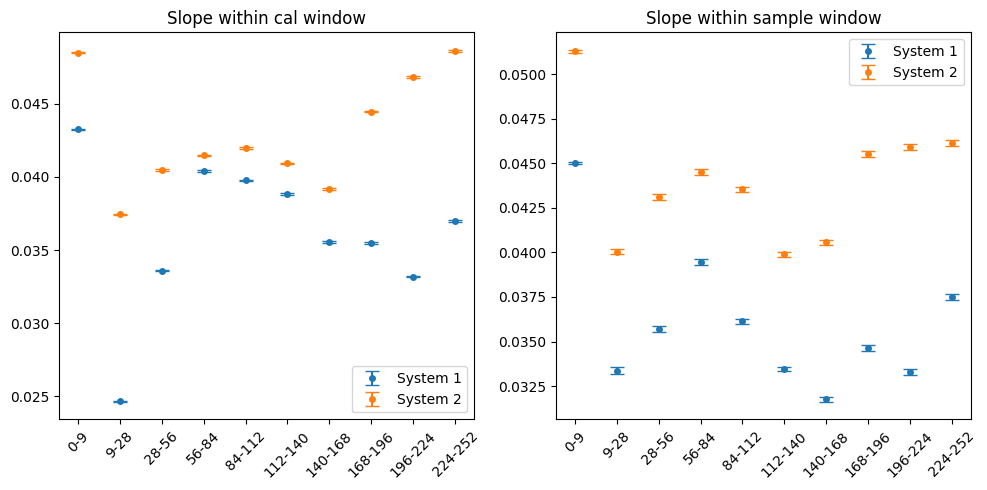

In [18]:
# Plot of slopes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-1-cal-slope"], yerr=Sensor_B_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-2-cal-slope"], yerr=Sensor_B_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-1-sample-slope"], yerr=Sensor_B_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-2-sample-slope"], yerr=Sensor_B_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

plt.tight_layout()
plt.show()


In [19]:
# T-tests to compare slopes in each bin
ttest_B = run_ttest(Sensor_B_slopes, N_B1_cal, N_B2_cal, N_B1_sample, N_B2_sample, labels)
ttest_B

,t-statistic-cal,p-value-cal,t-statistic-sample,p-value-sample
0-9,-111.365390,0.0,-53.852949,0.0
9-28,-267.120423,0.0,-27.882981,0.0
28-56,-123.227264,0.0,-34.342816,0.0
56-84,-14.308112,0.0,-20.140767,0.0
84-112,-33.840359,0.0,-34.454003,0.0
112-140,-31.266411,0.0,-32.960107,0.0
140-168,-58.204522,0.0,-43.582285,0.0
168-196,-121.069388,0.0,-47.298521,0.0
196-224,-182.233730,0.0,-54.762169,0.0
224-252,-138.746938,0.0,-37.959927,0.0
